# Jena Germany Climate Analysis

## Target

Predicting time-series dataset by RNN, including 2 parts: predicting on the time-series dataset with a single variable (1 feature) and predicting on time-series dataset with multiple variables (multiple features).

# Theory Review

## RNN equations

Diagram and equations of vanila RNN for 3 timesteps with inputs $\mathbf{x}_t$, 1 hidden layer $\mathbf{h}_t$, and 1 softmax layer for output $\mathbf{\hat{y}}_t$.

- $\mathbf{{h}}_t = \gamma(W_h\mathbf{h}_{t-1} + W_x\mathbf{x}_{t} + \mathbf{b}_h)$
- $\mathbf{\hat{y}}_t = s(W_y\mathbf{h}_t + \mathbf{b}_y)$

## Weight-sharing in time

What is weight-sharing in RNN and why is it useful?

- When we *unroll* an RNN in time, we have a cascade of FNNs (feed-forward) with exactly *same* set of parameters $(W_h, W_x, W_y, b_h, b_y)$. This is called "weight-sharing in time" and it helps reduce the number of learning parameters, making RNNs very efficient models for training.

## BPTT training

Gradient-based training method for RNN:

- Gradient-based method: backpropagation through time (BPTT) 
  1. Treat the unfolded network as a big feed-forward network. 
  2. The whole input sequence is given to the FFNN. 
  3. The weight updates are computed for each copy in the unfolded network using the usual back-propagation method.
  4. All the updates are then summed (or averaged) and then applied to the RNN (shared) weights.



# Analysis

## Import Libraries

In [1]:
import tensorflow as tf
tf.random.set_seed(1612)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## Setting cho matplotlib.pyplot

In [2]:
# matplotlib options
mpl.rcParams['figure.figsize'] = (15, 8) # default figsize
mpl.rcParams['axes.grid'] = False # turn off grid by default

## Reference

[How to Convert a Time Series to a Supervised Learning Problem in Python (with labels)](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

## Climate dataset

This [Climate Dataset](https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip) has 14 different features: air temperature, air pressure, humidity,... in Jena, Germany, recorded every 10 minutes, from 2003 to 2016. 

I will download the dataset directly from Google storage.

Index	| Features |	Format	| Description
--- | --- | --- | --- 
1	| Date Time	| 01.01.2009 00:10:00	| Date-time reference
2	| p (mbar)	| 996.52	| The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3	| T (degC)	| -8.02	| Temperature in Celsius
4	| Tpot (K)	| 265.4	| Temperature in Kelvin
5	| Tdew (degC)	| -8.9	| Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6	| rh (%)	| 93.3	| Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7	| VPmax (mbar)	| 3.33	| Saturation vapor pressure
8	| VPact (mbar)	| 3.11	| Vapor pressure
9	| VPdef (mbar)	| 0.22	| Vapor pressure deficit
10	| sh (g/kg)	| 1.94	| Specific humidity
11	| H2OC (mmol/mol)	| 3.12	| Water vapor concentration
12	| rho (g/m ** 3)	| 1307.75	| Airtight
13	| wv (m/s)	| 1.03	| Wind speed
14	| max. wv (m/s)	| 1.75	| Maximum wind speed
15	| wd (deg)	| 152.3	| Wind direction in degrees

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


## Read the CSV file

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.shape

(420551, 15)

In [6]:
df.tail(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420541,31.12.2016 22:30:00,1000.44,-4.08,269.05,-7.89,74.60,4.51,3.37,1.15,2.10,3.37,1293.55,1.27,2.48,192.1
420542,31.12.2016 22:40:00,1000.45,-4.45,268.68,-7.15,81.30,4.39,3.57,0.82,2.22,3.57,1295.24,0.80,1.44,183.8
420543,31.12.2016 22:50:00,1000.32,-4.09,269.05,-7.23,78.60,4.51,3.54,0.96,2.21,3.54,1293.37,1.25,1.60,199.2
420544,31.12.2016 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.7
420545,31.12.2016 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


If I would like to predict the temperates of **the next 6 hours on the dataset of the nearest 3 hours**, I would have to create windows, each has 18 (3 x 6) data patterns.

The below function will help to do that. `history_size` is the window size (18), target_size is the terperature index I would like to know (6).

The below function is inspired from the above reference link.

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

I will choose the first 300k rows to make them the Train set (about 2083 days). The rest will be the Test set.

In [8]:
TRAIN_SPLIT = 300000

**Note**

The below model's result might be not good enough. The reason is that in the dataset, it has 14 different features while I will use only 3 features to predict temperature for this project version.

## Predict the time-series data with single variable

I will train the model by only 1 feature `temperature` to predict temperature in the future.

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

## Plot to observe termperature's fluctuation by `.plot`

I will use `.plot` built in Dataframe (uni_data)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb43481f0d0>],
      dtype=object)

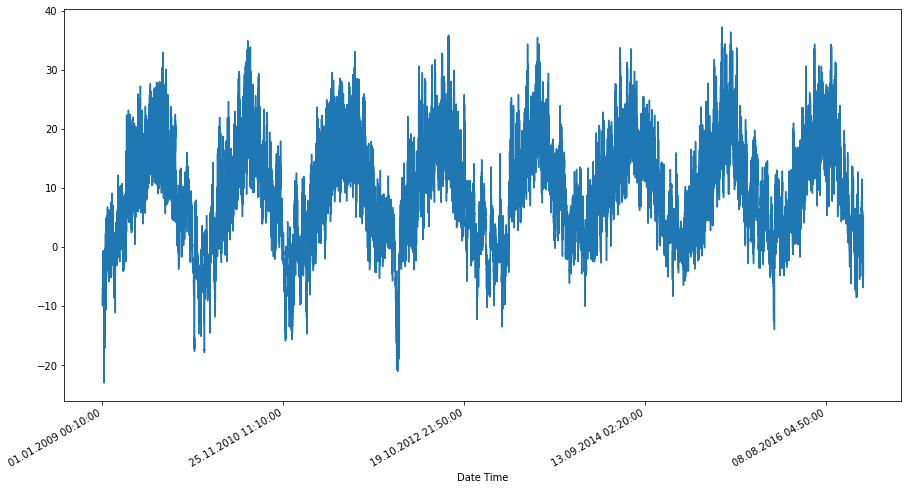

In [10]:
# call .plot() function with parameter subplots=True
uni_data.plot(subplots=True)

## Tranform data type from Dataframe into Numpy Array

In [11]:
# 1. Convert all uni_data into Numpy Array
# 2. It should be uni_data = unit_data.something
uni_data = uni_data.values

## Normalize the dataset


Note: Mean and Standard deviation should be calculated by the Train set.

From the above step, I have chose the first 300k rows as the Train set.
```
TRAIN_SPLIT = 300000
```
So, I will **calculate mean and std on these 300k rows**, then apply for the whole uni_data.

**Note: I will do it manually, not by using Standard Scaler from the library**

**Further details**

* If the variable A has a Numpy Array type, I will calculate mean and std of A by using A.mean() and A.std()

* Standard Scaler's formula

  $X_{scale} = \frac{X - mean(X)}{std(X)}$

* Keep the variable name as uni_data after scaling

In [12]:
# 1. Find mean and std on first 300k rows of uni_data
# 2. Apply scale on uni_data
# 3. Keep variable name (uni_data)
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std

Here, I will predict temperate of the next time step by **the previous 20 time patterns**.

In [13]:
# 1. Set the value for past_history

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [14]:
x_train_uni.shape, y_train_uni.shape

((299980, 20, 1), (299980,))

In [15]:
print ('Example of data window')
print (x_train_uni[0])
print ('\n Target to be predicted')
print (y_train_uni[0])

Example of data window
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target to be predicted
-2.1041848598100876


In [16]:
print ('Example of data window')
print (x_train_uni[1])
print ('\n Target to be predicted')
print (y_train_uni[1])

Example of data window
[[-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Target to be predicted
-2.0949220845536356



## Plot the Trained Model

In [17]:
# Create X-axis for plotting
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [18]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data): #return (index, value)
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

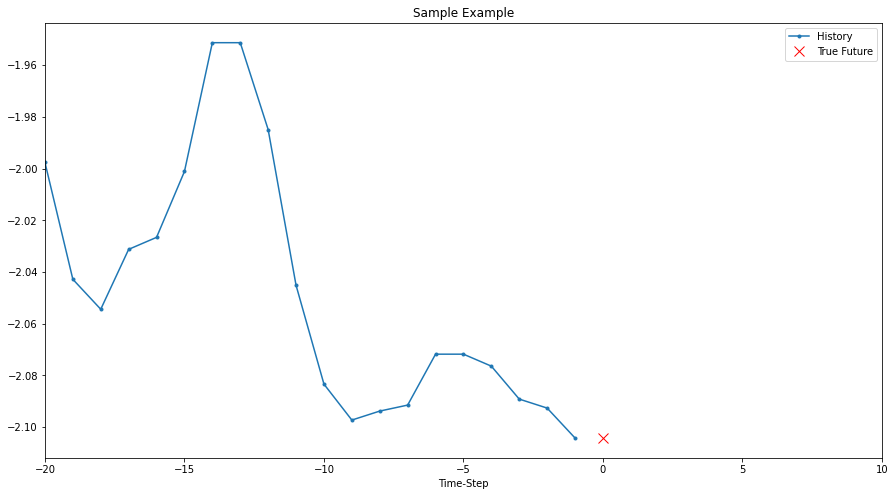

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline

Before designing the model, I will try to predict the current temperature by calculating an average of the previous 20 time steps (a naive approach).

In [20]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

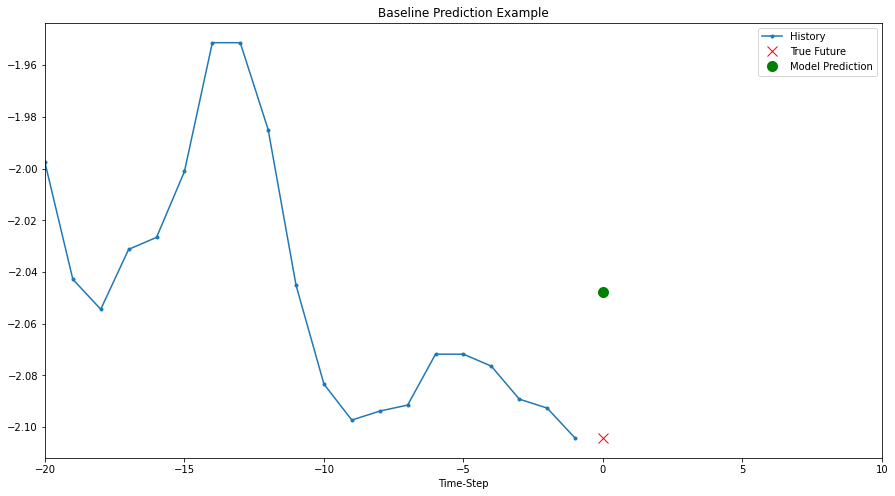

In [21]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

### Simple RNN versus LSTM



I will use tf.data to shuffle the dataset randomly, arrange in batches, and store (data) in a cache memory.

https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset

In [22]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)

RNN model will ask to declare input shape as type (window size, predicted number/temperature). So, here it is (20,1) (x_train_uni.shape[1:])

In [23]:
x_train_uni.shape

(299980, 20, 1)

I will use SimpleRNN first (a simple model include 1 layer of SimpleRNN and 1 output layer of Dense)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

**Note**

* If there are 2 layers SimpleRNN (or LSTM) simutaneously, it should be added with a parameter return_sequences=True

* Connecting from SimpleRNN layer (or LSTM) to Dense does not require the return_sequences=True

In [44]:
# 1. Define architecture for simple_rnn model
# 2. input_shape=x_train_uni.shape[1:]
# 3. Model should have 1 SimpleRNN layer and 1 Dense layer as output
# 4. Fit model using mse loss and adam optimizer
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(16, input_shape=x_train_uni.shape[1:]))
simple_rnn.add(Dense(1))

simple_rnn.compile(loss='mse', optimizer='adam')
simple_rnn.fit(train_univariate, epochs=10,
                      validation_data=val_univariate)


Epoch 1/10
1172/1172 [==============================] - 37s 31ms/step - loss: 0.0104 - val_loss: 0.0017
Epoch 2/10
1172/1172 [==============================] - 35s 30ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/10
1172/1172 [==============================] - 35s 30ms/step - loss: 0.0010 - val_loss: 8.1833e-04
Epoch 4/10
1172/1172 [==============================] - 36s 30ms/step - loss: 7.4862e-04 - val_loss: 6.4242e-04
Epoch 5/10
1172/1172 [==============================] - 38s 32ms/step - loss: 6.2796e-04 - val_loss: 5.5820e-04
Epoch 6/10
1172/1172 [==============================] - 41s 35ms/step - loss: 5.8700e-04 - val_loss: 5.6513e-04
Epoch 7/10
1172/1172 [==============================] - 41s 35ms/step - loss: 5.8703e-04 - val_loss: 6.1305e-04
Epoch 8/10
1172/1172 [==============================] - 39s 33ms/step - loss: 5.8542e-04 - val_loss: 5.5037e-04
Epoch 9/10
1172/1172 [==============================] - 40s 34ms/step - loss: 5.8006e-04 - val_loss: 5.5621e-04
Epoch 10/10


I will take 3 patterns in the validation set (val)univariate) to observe how the SimpleRNN model predicted.

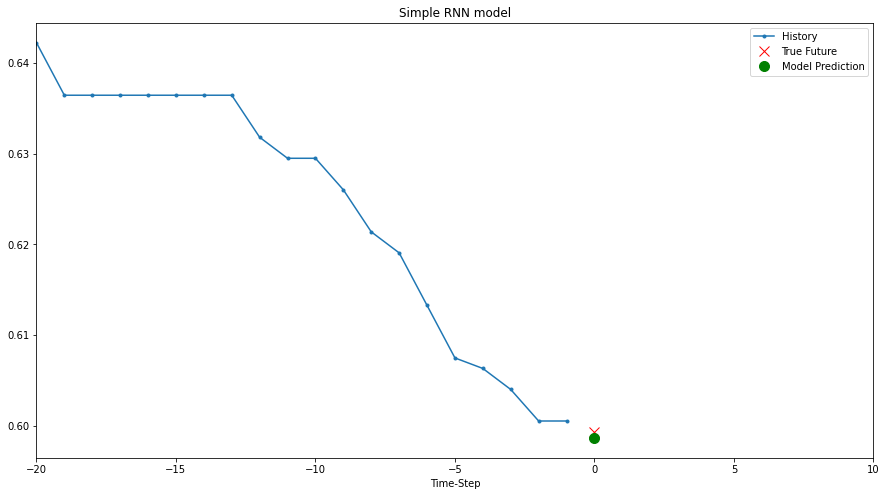

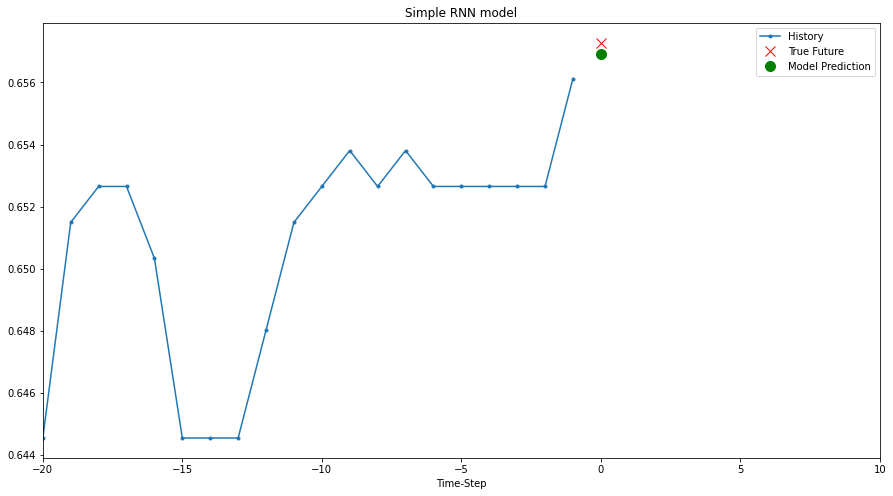

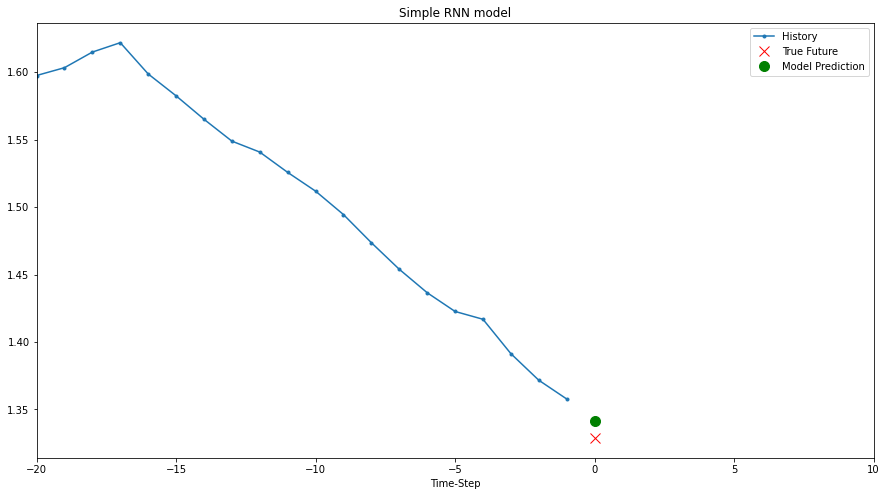

In [26]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_rnn.predict(x)[0]], 0, 'Simple RNN model')
  plot.show()

Next, I will replace SimpleRNN layer with LSTM to see if the model could predict more efficiently.

**Note**

The implemention way of LSTM is similar to the one of SimpleRNN.

The model architecture of simple_lstm should be similar to the one of simple_rnn, I will only replace SimpleRNN by LSTM.

In [27]:
# 1. Define architecture for simple_lstm model
# 2. Model should be the same like simple_rnn, you just have to replace SimpleRNN with LSTM
# 3. Fit model using mse loss and adam optimizer

simple_lstm = Sequential()
simple_lstm.add(LSTM(16, input_shape=x_train_uni.shape[1:]))
simple_lstm.add(Dense(1))

simple_lstm.compile(loss='mse', optimizer='adam')
simple_lstm.fit(train_univariate, epochs=10,
                      validation_data=val_univariate)

Epoch 1/10
1172/1172 [==============================] - 15s 9ms/step - loss: 0.0206 - val_loss: 0.0024
Epoch 2/10
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/10
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/10
1172/1172 [==============================] - 10s 9ms/step - loss: 0.0011 - val_loss: 9.3165e-04
Epoch 5/10
1172/1172 [==============================] - 10s 9ms/step - loss: 8.6678e-04 - val_loss: 7.2047e-04
Epoch 6/10
1172/1172 [==============================] - 10s 9ms/step - loss: 6.9130e-04 - val_loss: 5.8931e-04
Epoch 7/10
1172/1172 [==============================] - 10s 9ms/step - loss: 6.0157e-04 - val_loss: 6.1150e-04
Epoch 8/10
1172/1172 [==============================] - 10s 9ms/step - loss: 5.7605e-04 - val_loss: 5.3958e-04
Epoch 9/10
1172/1172 [==============================] - 10s 9ms/step - loss: 5.6990e-04 - val_loss: 5.5533e-04
Epoch 10/10
1172/1172 [======

Similarly, I will use 3 patterns in the validation set to observer the model's results.

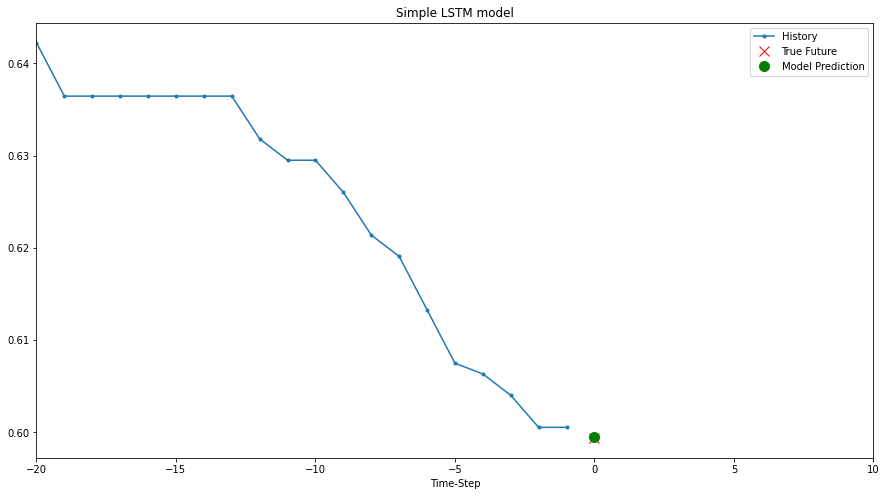

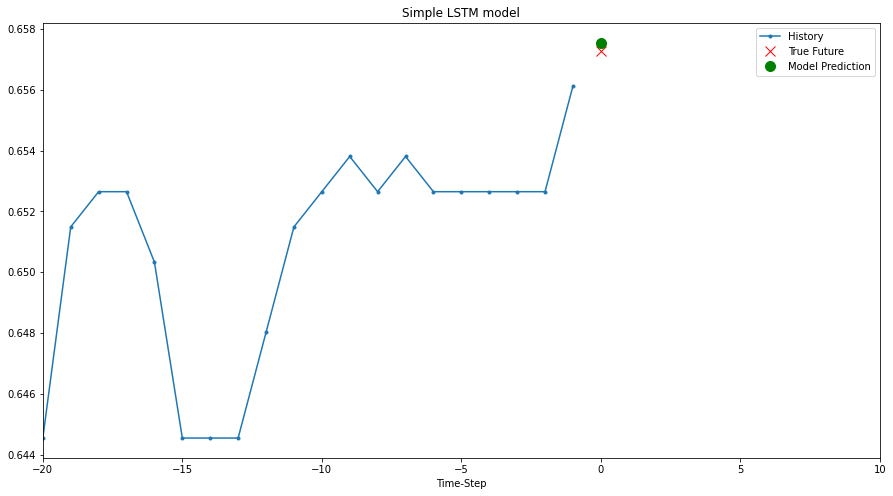

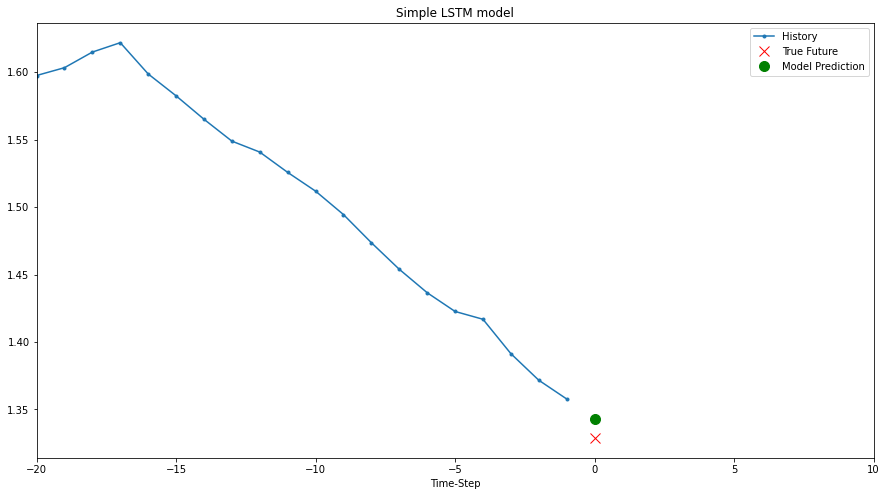

In [45]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Predict the Time-Series data with multiple variables

I will predict temperature by 3 features: pressure, temperature and air tight.

In [29]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [30]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


## Plot to observe how the features change over time

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb431c33c50>,
      dtype=object)

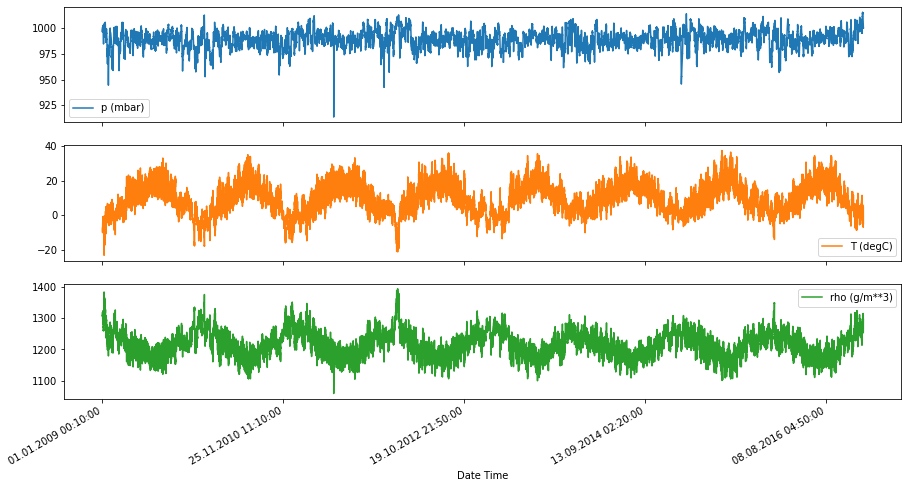

In [31]:
features.plot(subplots=True)

Similarly as above, I will scale the data first.

The method is the same but I have many features here so I will need a parameter - axis.

In [32]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [33]:
dataset.shape

(420551, 3)

## Prediction model of a new temperature point

In this section, the model will learn and predict a new temperature point based on the known data points (temperature, pressure, airtight).

In [34]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

The data in the dataset is recorded every 10 minutes. So in 1 hour, it will be recorded 6 times.

I will predict the new temperature point from the dataset of the previous 5 days (5 x 24 x 6) = 720 data points.

Within 1 hour, there will not enough fluctuations so I will get data points separated by 1 hour. So, 720 / 6 = 120 data points.

I would like to predict temperature of the next 12 hours. So, the target is the point separated by 12 x 6 = 72 steps from the current point.

In [35]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

## Check if the data has exactly 120 points and 3 features

In [36]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [37]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE)

## Model with multi-layered LSTM

*Note*

* If there are 2 simultaneous SimpleRNN layers (or LSTM), I will not need the parameter return_sequences=True

* Connecting the SimpleRNN layer (or LSTM) to Dense does not require the return_sequences=True.

### Define architecture for deep_lstm model

In [39]:
# 1. Define architecture for deep_lstm model
# 2. input_shape=x_train_single.shape[1:]
# 3. Fit model using mse loss and adam optimizer
deep_lstm = Sequential()
deep_lstm.add(LSTM(16, return_sequences=True,input_shape=x_train_single.shape[1:]))
deep_lstm.add(LSTM(16, return_sequences=True))
deep_lstm.add(LSTM(16))
deep_lstm.add(Dense(1))

deep_lstm.compile(loss='mse', optimizer='adam')
history = deep_lstm.fit(train_data_single, epochs=10,
                      validation_data=val_data_single)


Epoch 1/10
1170/1170 [==============================] - 106s 86ms/step - loss: 0.1352 - val_loss: 0.1235
Epoch 2/10
1170/1170 [==============================] - 99s 85ms/step - loss: 0.1030 - val_loss: 0.1243
Epoch 3/10
1170/1170 [==============================] - 99s 85ms/step - loss: 0.0973 - val_loss: 0.1128
Epoch 4/10
1170/1170 [==============================] - 99s 85ms/step - loss: 0.0927 - val_loss: 0.1122
Epoch 5/10
1170/1170 [==============================] - 99s 84ms/step - loss: 0.0898 - val_loss: 0.1119
Epoch 6/10
1170/1170 [==============================] - 98s 84ms/step - loss: 0.0866 - val_loss: 0.1110
Epoch 7/10
1170/1170 [==============================] - 98s 84ms/step - loss: 0.0842 - val_loss: 0.1125
Epoch 8/10
1170/1170 [==============================] - 98s 84ms/step - loss: 0.0814 - val_loss: 0.1108
Epoch 9/10
1170/1170 [==============================] - 98s 84ms/step - loss: 0.0798 - val_loss: 0.1130
Epoch 10/10
1170/1170 [==============================] - 98s 84

In [40]:
deep_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 120, 16)           1280      
                                                                 
 lstm_2 (LSTM)               (None, 120, 16)           2112      
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
_________________________________________________________________


### Plot train history

In [41]:
def plot_train_history(history, title):
  
  plt.figure()

  plt.plot(history.history['loss'], 'b', label='Training loss')
  plt.plot(history.history['val_loss'], 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

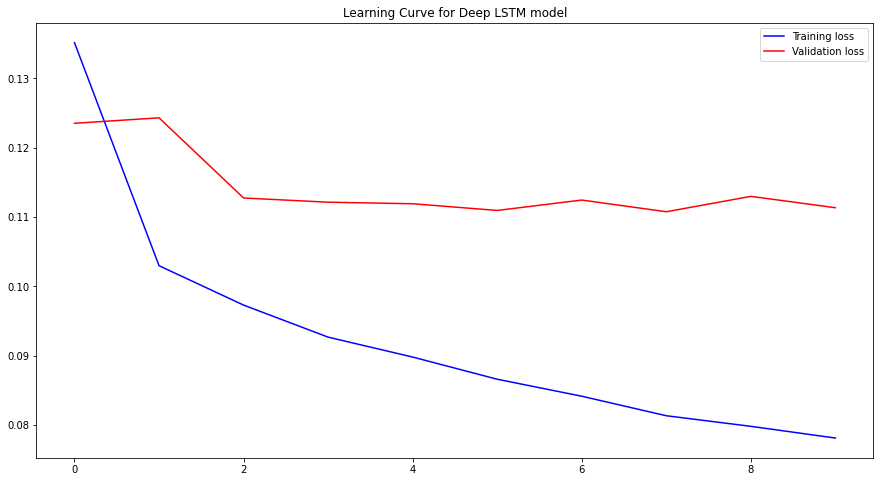

In [43]:
plot_train_history(history,
                   'Learning Curve for Deep LSTM model')

### Predict and draw a prediction line chart


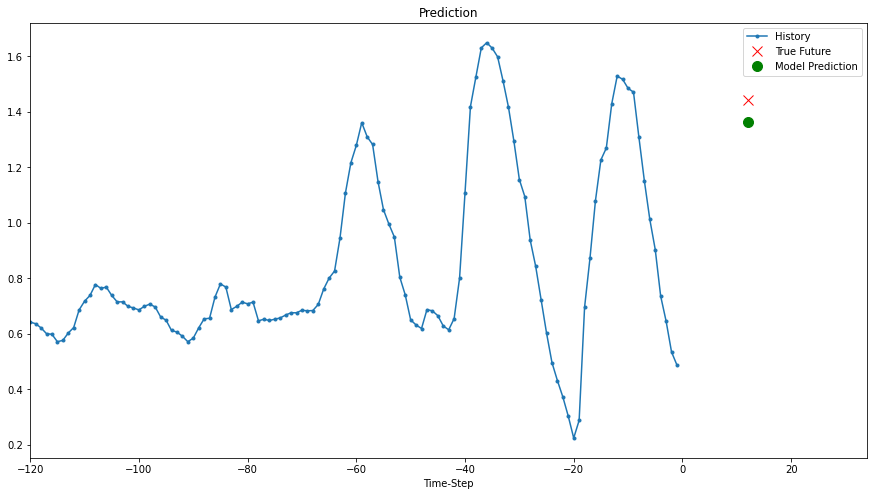

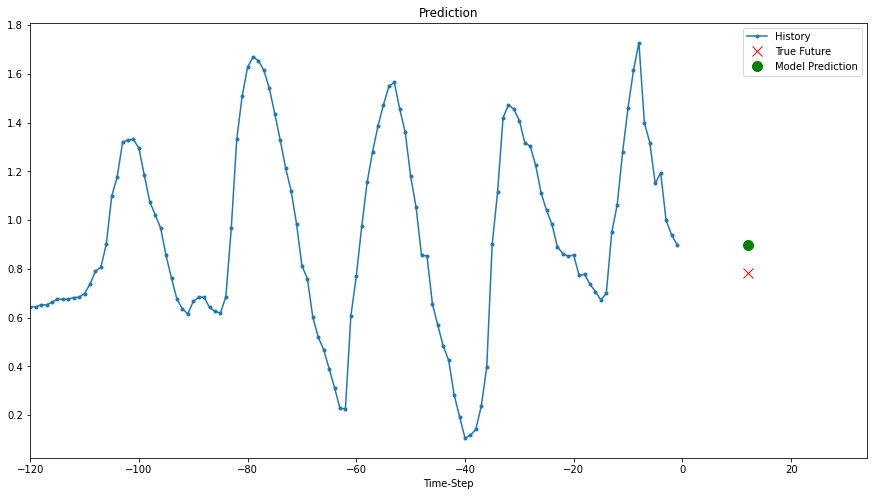

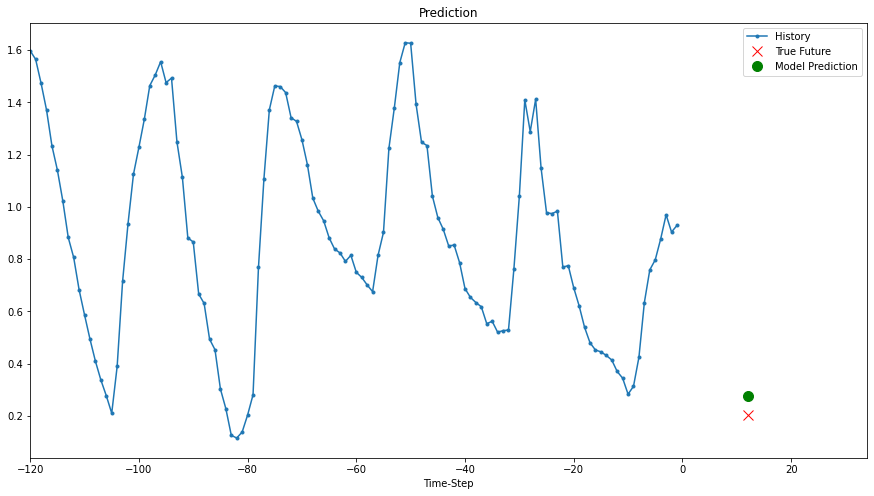

In [42]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    deep_lstm.predict(x)[0]], 12,
                   'Prediction')
  plot.show()